# Path Planning using the Visibility Graph Method

<a target="_blank" href="https://colab.research.google.com/github/arthurrichards77/smply/blob/master/visibility.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This is one of the road map approaches, based on the observation that the shortest path will just scrape the corners of the obstacles.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

Define a start point, a goal point, and some obstacles represented as polygons.  Then plot the world, including a handy utility for plotting closed polygons.

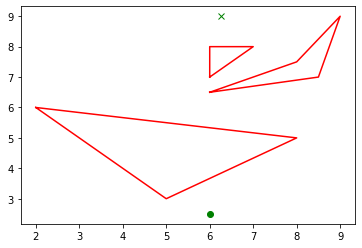

In [2]:
obstacles = [np.array([[2.,6.],[8.,5.],[5.,3.]]),np.array([[6.,6.5],[8.5,7.],[9.,9.],[8.,7.5]]),np.array([[6,7],[7,8],[6,8]])]
start = [6.,2.5]
goal = [6.25,9.]

#obstacles = obstacles.append([np.array([[6,7],[7,8],[6,8]])])

def plot_poly(points,fmt='b-',**kwargs):
    plt.plot(np.append(points[:,0],points[0,0]),np.append(points[:,1],points[0,1]),fmt)

for ob in obstacles:
    plot_poly(ob,'r-')

plt.plot(start[0],start[1],'go',goal[0],goal[1],'gx')
plt.show()

Plot the line between all pairs of vertices, including the start and goal.  This will be a mess, but it's our starting point.

> For a large number of obstacles, any 'all pairs' operation will be a big computation.  Luckily we don't have much do with each.

Notice that I'm putting all the nodes into the one `all_points` list, with the goal as the first entry and the start point as the second.  We'll need that information later when we reconstruct the path.

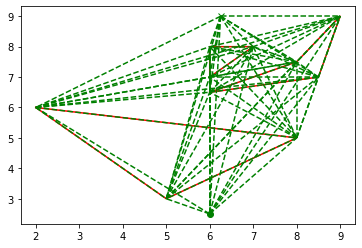

In [3]:
for ob in obstacles:
    plot_poly(ob,'r-')
plt.plot(start[0],start[1],'go',goal[0],goal[1],'gx')

all_points = np.array([goal,start])
for ob in obstacles:
    all_points = np.append(all_points,ob[:],0)
for ii in range(len(all_points)):
    for jj in range(ii+1,len(all_points)):
        plt.plot(all_points[[ii,jj],0],all_points[[ii,jj],1],'g--')
plt.show()

Now we need to knock out those lines that intersect the obstacles.  This is non-trivial, and I've not done it the most efficient way here, but you get the idea.  Fundamentally, the visibility test starts by checking if the line crosses with any of the sides of any of the obstacles.  *But* there's a catch: a line completely inside an obstacle would pass that test.  We could try knocking out any line that *touches* an obstacle, but then we lose the lines running round the obstacle edges.  Here I use an extra test where you check from the midpoint of the line under test to a point in the outside world.  If that crosses an off number of edges, we must be inside.
> Key lesson: simple things like "can I see from A to B?" can be more complicated than you think

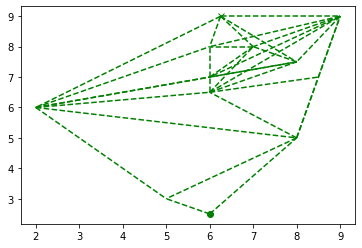

In [4]:
def lines_cross(a,b,c,d):
    if np.all(a==c) and np.all(b==d):
        print('same')
        return(False)
    if np.all(a==d) and np.all(b==c):
        print('same, reversed')
        return(False)
    M = np.array([[b[0]-a[0],c[0]-d[0]],[b[1]-a[1],c[1]-d[1]]])
    if np.linalg.det(M)==0.:
        return(False)
    v = np.array([[c[0]-a[0]],[c[1]-a[1]]])
    w = np.linalg.solve(M,v)
    tol = 1e-9
    if w[0]<=tol:
        return(False)
    elif w[0]>=1-tol:
        return(False)
    elif w[1]<=tol:
        return(False)
    elif w[1]>=1-tol:
        return(False)
    else:
        return(True)
    
def line_crosses_obst(a,b,obst):
    for ii in range(len(obst)):
        if np.all(a==obst[ii-1]) and np.all(b==obst[ii]):
            return(False)
        if np.all(b==obst[ii-1]) and np.all(a==obst[ii]):
            return(False)
        if lines_cross(a,b,obst[ii-1],obst[ii]):
            return(True)
    # extra test in case line is completely inside
    num_crosses = 0
    for ii in range(len(obst)):
        if lines_cross(0.5*(a+b),[max(obst[:,0])+0.01,max(obst[:,1])+0.01],obst[ii-1],obst[ii]):
            num_crosses = num_crosses+1
    if num_crosses%2==1:
        return(True)
    return(False)
            
def is_visible(a,b,obstacles):
    for ob in obstacles:
        if line_crosses_obst(a,b,ob):
            #print(a,b,'crosses obst',ob)
            return(False)
    return(True)

for ii in range(len(all_points)):
    for jj in range(ii+1,len(all_points)):
        if is_visible(all_points[ii],all_points[jj],obstacles):
            plt.plot(all_points[[ii,jj],0],all_points[[ii,jj],1],'g--')

#for ob in obstacles:
    #plot_poly(ob,'r-')
plt.plot(start[0],start[1],'go',goal[0],goal[1],'gx')
plt.show()

Great - this is the 'visibility graph', and all of its edges can be traveled.

> Note I've missed the clever step of taking out concave points.  That won't hurt us much here.

The next step is to construct the matrix of distances, with entry *C(i,j)* being the distance from point *i* to point *j*.  If *i* and *j* can't see eachother, then the cost is infinity.  We also assume the the *i-j* distance is the same as *j-i*, so the matrix is symmetric.

In [5]:
C = np.inf+np.zeros((len(all_points),len(all_points)))

for ii in range(len(all_points)):
    for jj in range(ii+1,len(all_points)):
        if is_visible(all_points[ii],all_points[jj],obstacles):
            C[ii,jj]=np.linalg.norm(all_points[ii]-all_points[jj])
            C[jj,ii]=C[ii,jj]

C

array([[       inf,        inf, 5.20216301,        inf,        inf,
               inf,        inf, 2.75      , 2.30488611,        inf,
        1.25      , 1.03077641],
       [       inf,        inf,        inf, 3.20156212, 1.11803399,
               inf,        inf,        inf,        inf,        inf,
               inf,        inf],
       [5.20216301,        inf,        inf, 6.08276253, 4.24264069,
        4.03112887,        inf,        inf, 6.18465844, 4.12310563,
               inf, 4.47213595],
       [       inf, 3.20156212, 6.08276253,        inf, 3.60555128,
        2.5       , 2.06155281, 4.12310563,        inf,        inf,
               inf,        inf],
       [       inf, 1.11803399, 4.24264069, 3.60555128,        inf,
               inf,        inf,        inf,        inf,        inf,
               inf,        inf],
       [       inf,        inf, 4.03112887, 2.5       ,        inf,
               inf, 2.54950976, 3.90512484, 2.23606798, 0.5       ,
        1.80277564,

This is now ready for a graph search, and happily one is built into SciPy: see (https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.sparse.csgraph.shortest_path.html) for details.  Note the option to get the 'predecessors' matrix back as an output, so we can reconstruct the path.  You could do this just using the distance matrix but this way is quicker.

In [6]:
from scipy.sparse.csgraph import shortest_path
distance,predecessors = shortest_path(C, return_predecessors=True)
print(distance)
print(predecessors)

[[0.         8.23233853 5.20216301 5.03077641 8.63632768 2.53077641
  4.81155281 2.75       2.30488611 2.03077641 1.25       1.03077641]
 [8.23233853 0.         5.36067468 3.20156212 1.11803399 5.70156212
  5.26311493 7.32466774 7.9376301  6.20156212 7.50433776 7.20156212]
 [5.20216301 5.36067468 0.         6.08276253 4.24264069 4.03112887
  6.58063863 7.63441362 6.18465844 4.12310563 5.47213595 4.47213595]
 [5.03077641 3.20156212 6.08276253 0.         3.60555128 2.5
  2.06155281 4.12310563 4.73606798 3.         4.30277564 4.        ]
 [8.63632768 1.11803399 4.24264069 3.60555128 0.         6.10555128
  5.66710409 7.7286569  8.34161925 6.60555128 7.90832691 7.60555128]
 [2.53077641 5.70156212 4.03112887 2.5        6.10555128 0.
  2.54950976 3.90512484 2.23606798 0.5        1.80277564 1.5       ]
 [4.81155281 5.26311493 6.58063863 2.06155281 5.66710409 2.54950976
  0.         2.06155281 3.86432845 3.04950976 4.29762079 4.04950976]
 [2.75       7.32466774 7.63441362 4.12310563 7.7286569 

Nearly there!  The algorithm here has actually computed shortest paths between all pairs of nodes in the graph, but we just need the one from node 1 (the start) to node 0 (the goal).  The `predecessors` matrix is arranged such that *P(j,i)* is the next node on the shortest path from *i* to *j*.  That means I have to walk along the graph from the current node towards $0$ at each step, starting from node $1$.

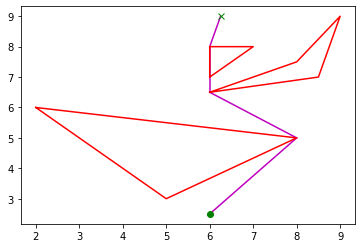

In [7]:
curr_node = 1
for kk in range(len(all_points)):
    next_node = predecessors[0,curr_node]
    plt.plot(all_points[[curr_node,next_node],0],all_points[[curr_node,next_node],1],'m-')
    curr_node=next_node
    if curr_node==0:
        break
        
for ob in obstacles:
    plot_poly(ob,'r-')
plt.plot(start[0],start[1],'go',goal[0],goal[1],'gx')
plt.show()

Bingo! One shortest path from start to goal avoiding the obstacles.